# Isabella Salgado Pinzón - 201730418
# Juan Pablo Naranjo - 201730006

Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests

API_KEY = 'ei_33c91c2f534efddf85e7c7e0827caeb468ceba5439faa4e026efda1be1016630'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/65436/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/65436/training/5/y')


Cargar imágenes

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

### Preparación de datos

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "lamp", "pen", "unknown" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


## Definición de Red (Secuencial)

Keras permite definir redes convolucionales utilizando un modelo conocido como Secuencial, en el cual se define un modelo, y se le van agregando capas según la arquitectura definida.

Utilice la arquitectura _MobileNetV2 96x96 0.35_

- Agregue una capa fully-connected/Dense con 8 neuronas, función de activación ReLu
- Agregue una capa de Dropout con una probabilidad del 10%
- Convierta el resultado matricial en un vector
- Agregue una capa fully-connected/Dense con el mismo número clases que neuronas, función de activación Softmax
- Compile la versión final del modelo con los parámetros:
  - Optimizador Adam con una tasa de aprendizaje 0.0005
  - Función de pérdida `categorical_crossentropy`
  - Métricas: `accuracy`


Puede leer un poco más sobre las redes MobileNet en el artículo aquí [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861)

Acá puede observar un [ejemplo](https://www.tensorflow.org/tutorials/images/cnn) sobre cómo definir un modelo de CNN con la arquitectura:

1. 32 filtros con un Kernel de 3x3 (convolución en 2D) para una entrada de tamaño 32x32x3 (32x32 pixeles RGB), función de activación ReLu.
2. [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) con un Kernel de 2x2.
3. 64 filtros con un Kernel de 3x3, función de activación ReLu.
4. MaxPooling2D con un Kernel 2x2
5. 64 filtros con un Kernel de 3x3, función de activación ReLu.


```
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
```

In [4]:
import math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy


WEIGHTS_PATH = './transfer-learning-weights/keras/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_96.h5'
# Download the model weights
root_url = 'http://cdn.edgeimpulse.com/'
p = Path(WEIGHTS_PATH)
if not p.exists():
    if not p.parent.exists():
        p.parent.mkdir(parents=True)
    weights = requests.get(root_url + WEIGHTS_PATH[2:]).content
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(weights)

INPUT_SHAPE = (96, 96, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape = INPUT_SHAPE, alpha=0.35,
    weights = WEIGHTS_PATH
)

base_model.trainable = False

model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE, name='x_input'))

# Don't include the base model's top layers
last_layer_index = -3
model.add(Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])


# Set the data to the expected input shape
train_dataset = train_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)

# Implements the data augmentation policy
def augment_image(image, label):
    # Flips the image randomly
    image = tf.image.random_flip_left_right(image)

    # Increase the image size, then randomly crop it down to
    # the original dimensions
    resize_factor = random.uniform(1, 1.2)
    new_height = math.floor(resize_factor * INPUT_SHAPE[0])
    new_width = math.floor(resize_factor * INPUT_SHAPE[1])
    image = tf.image.resize_with_crop_or_pad(image, new_height, new_width)
    image = tf.image.random_crop(image, size=INPUT_SHAPE)

    # Vary the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image, label

train_dataset = train_dataset.map(augment_image, tf.data.experimental.AUTOTUNE)

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

model.fit(train_dataset, validation_data=validation_dataset, epochs=20, verbose=2, callbacks=callbacks)

print('')
print('Initial training done.', flush=True)

# How many epochs we will fine tune the model
FINE_TUNE_EPOCHS = 10
# What percentage of the base model's layers we will fine tune
FINE_TUNE_PERCENTAGE = 65

print('Fine-tuning model for {} epochs...'.format(FINE_TUNE_EPOCHS), flush=True)

# Determine which layer to begin fine tuning at
model_layer_count = len(model.layers)
fine_tune_from = math.ceil(model_layer_count * ((100 - FINE_TUNE_PERCENTAGE) / 100))

# Allow the entire base model to be trained
model.trainable = True
# Freeze all the layers before the 'fine_tune_from' layer
for layer in model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000045),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset,
                epochs=FINE_TUNE_EPOCHS,
                verbose=2,
                validation_data=validation_dataset,
                callbacks=callbacks,
                class_weight=None
            )

Epoch 1/20
4/4 - 2s - loss: 1.0803 - accuracy: 0.4583 - val_loss: 1.0193 - val_accuracy: 0.6000 - 2s/epoch - 617ms/step
Epoch 2/20
4/4 - 0s - loss: 0.8281 - accuracy: 0.6500 - val_loss: 0.9008 - val_accuracy: 0.6000 - 177ms/epoch - 44ms/step
Epoch 3/20
4/4 - 0s - loss: 0.6552 - accuracy: 0.7500 - val_loss: 0.8096 - val_accuracy: 0.6667 - 171ms/epoch - 43ms/step
Epoch 4/20
4/4 - 0s - loss: 0.6275 - accuracy: 0.7667 - val_loss: 0.7311 - val_accuracy: 0.7000 - 175ms/epoch - 44ms/step
Epoch 5/20
4/4 - 0s - loss: 0.4908 - accuracy: 0.8667 - val_loss: 0.6396 - val_accuracy: 0.7667 - 188ms/epoch - 47ms/step
Epoch 6/20
4/4 - 0s - loss: 0.4560 - accuracy: 0.8583 - val_loss: 0.5455 - val_accuracy: 0.8333 - 190ms/epoch - 47ms/step
Epoch 7/20
4/4 - 0s - loss: 0.3866 - accuracy: 0.8750 - val_loss: 0.4644 - val_accuracy: 0.8667 - 171ms/epoch - 43ms/step
Epoch 8/20
4/4 - 0s - loss: 0.2968 - accuracy: 0.9167 - val_loss: 0.4049 - val_accuracy: 0.9000 - 178ms/epoch - 44ms/step
Epoch 9/20
4/4 - 0s - loss

C:\Users\jpnar\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\jpnar\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


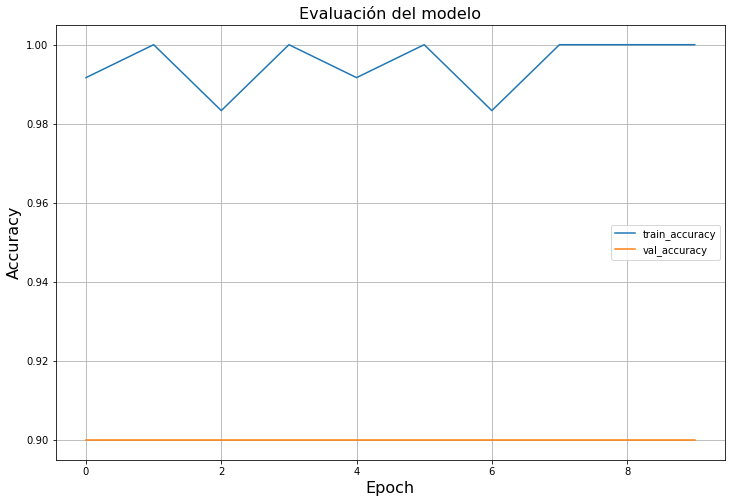

In [5]:
# Save the model to disk
model.save('saved_model')
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.grid()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Evaluación del modelo', fontsize=16)
plt.legend()